[View in Colaboratory](https://colab.research.google.com/github/star-ice/tensorflow/blob/master/Copy_of_community_detection.ipynb)

# Community Detection
In this session we shall use a community detection algorithm to discover large community of similar nodes in the graph we constructed in the earlier session "Finding pairwise dissimilarity from Siamese Network".

##Test case name
Please set the variable "name" below to a name of your choice. <br>
Use any name, but please choose one that does not conflict with others' choices, e.g. your name.<br>
**For the initial lab session, do not change this -- just leave this as "trial".**

In [0]:
name="trial"

## Imports

In [2]:
# Install GCP modules

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

# Install NetworkX module

!pip3 install networkx

torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


In [0]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import os
from google.colab import files, auth

## Helper functions

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
    
# Set use_gcp to False to download a file to your local harddisk
def backup(filename, use_gcp=True):
    if name == "trial" and use_gcp: # No backup for the trial
        print("File \"" + filename + "\" not backed up since this is a trial run")
        return
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy " + filename + " gs://harddisk-1/" + name + "/")
    else:
        files.download(filename)

# Set use_gcp to False to upload a file from your local harddisk
def restore(filename, use_gcp=True):
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy gs://harddisk-1/" + name + "/" + filename + " .")
    else:
        if os.path.exists(filename):
            os.remove(filename)
        uploaded = files.upload()
    !ls -l {filename}

# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G

# Save graph for use in Gephi or pals
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(filename, 'w')
    if header:
        f.write("Source,Target\n")
    for i in range(sim.shape[0]):
        for j in range(i+1, sim.shape[1]):
            if sim[i,j] != 0:
                if labels == None:
                    f.write(str(i) + delim + str(j) + "\r\n")
                else:
                    f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\r\n")                          
    f.close()

##Configuration

In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']
    labels = None

## Build graph
Construct an adjacency matrix from the dissimilarity matrix, then use the adjacency matrix to build a networkx graph


In [6]:
# Load a saved copy of the dissimilarity matrix

restore("_sim.txt")

# Loads the dissimilarity matrix (and node labels)

sim = np.loadtxt('_sim.txt')
print("Restored {}x{} matrix".format(sim.shape[0], sim.shape[1]))

-rw-r--r-- 1 root root 8100 Jul 14 08:14 _sim.txt
Restored 18x18 matrix


In [7]:
# Restore labels from saved "_labels.csv" file

restore("_labels.csv")

Config.labels = []
with open('_labels.csv') as f:
    for line in f:
        _, label = line.rstrip().split(",")
        Config.labels.append(label)

print("Loaded labels (" + str(len(Config.labels)) + " classes): ", end='')
print(Config.labels)

-rw-r--r-- 1 root root 114 Jul 14 08:14 _labels.csv
Loaded labels (18 classes): ['s1', 's10', 's11', 's14', 's18', 's21', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's34', 's37', 's40', 's41', 's8']


diagonal avg=157.30 min=108.60 max=215.52


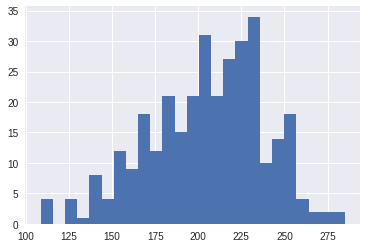

In [8]:
# Analyze distribution of dissimilarity score

d = np.diagonal(sim)
print('diagonal avg={0:.2f} min={1:.2f} max={2:.2f}'.format(np.mean(d), np.min(d), np.max(d)))
simflat = sim.reshape((-1,))
_ = plt.hist(simflat, bins=25)

In [9]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 170
adjmat = sim.reshape((-1,)).copy()
adjmat[adjmat > threshold] = 0
#adjmat[adjmat > 0] = 1
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)

271 out of 324 values set to zero


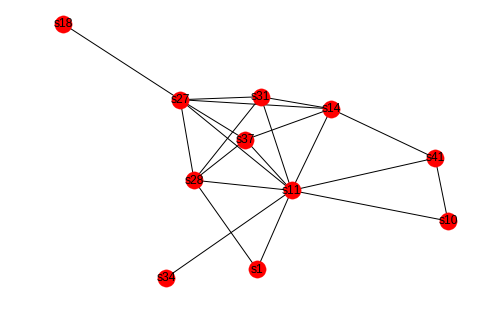

In [10]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)

G = make_graph(adjmat, labels=Config.labels)
nx.draw_spring(G, with_labels=True)

##Community detection using Girvan-Newman

Possibility 1 : ({'s37', 's41', 's31', 's28', 's10', 's18', 's27', 's1', 's14', 's11'}, {'s34'})


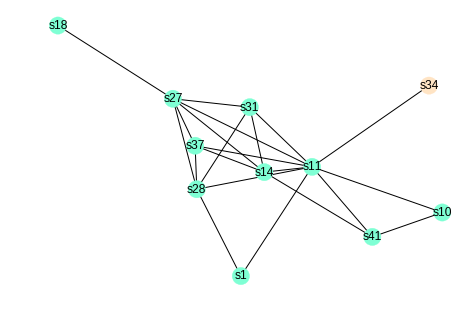

Possibility 2 : ({'s37', 's41', 's31', 's28', 's10', 's27', 's1', 's14', 's11'}, {'s34'}, {'s18'})


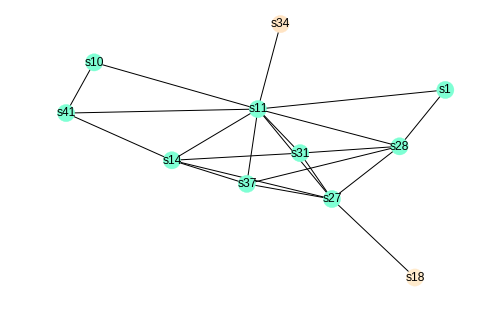

Possibility 3 : ({'s37', 's31', 's28', 's27', 's1', 's14', 's11'}, {'s10', 's41'}, {'s34'}, {'s18'})


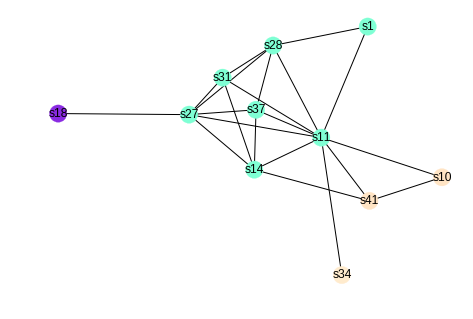

In [11]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 3
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possibility", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()


##Visualization

###Gephi
Gephi Download - https://gephi.org/users/download/<br>
Gephi HOWTO    - https://gephi.wordpress.com/2017/09/26/gephi-0-9-2-a-new-csv-importer/<br>
*(It is possible to colorize communities in Gephi - read here: https://github.com/kalngyk/repoman/raw/master/gephi_communities.pdf)*


In [0]:
# Generate and download edges for Gephi

export_edge_list(adjmat, labels=Config.labels, filename='gephi-edges.csv')
backup('gephi-edges.csv', False)

###pals
pals HOWTO - https://github.com/kalngyk/repoman/raw/master/usepals.pdf


In [0]:
# Generate the community file for pals system

which_possibility = 3

communities = possibilities[which_possibility-1]

indices_in_community = []   # For obtaining submatrix of adjmat

f = open("pals-community.dat", 'w')
cur_com = 1
for c in communities:
    indices = [i for i, x in enumerate(Config.labels) if x in c]
    indices_in_community.extend(indices)
    for i in indices:
         f.write("\"" + Config.labels[i] + "\" " + str(cur_com) + "\r\n")
    cur_com += 1
f.close()

backup("pals-community.dat", False)


# Generate the graph file for pals system

# Obtain the submatrix of adjmat with only elements that appear in communities
indices_in_community = sorted(indices_in_community)
adjmat_in_community = adjmat[indices_in_community,:][:,indices_in_community]

# Obtain sublist of labels of only elements that appear in communities
labels = np.array(Config.labels)[indices_in_community].tolist()

export_edge_list(adjmat_in_community, labels=labels, filename='pals-edges.dat', delim=" ", header=False)

backup('pals-edges.dat', False)
